In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sn
import matplotlib.pyplot as plt
from IPython.display import IFrame
import folium
import json
import math

from branca.colormap import LinearColormap, StepColormap, linear
from branca.element import MacroElement
from jinja2 import Template
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import SpectralClustering
from sklearn import mixture

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from functools import partial

In [2]:
data_folder = '../Data_sinan/'

## Future queries

From now, we will use the dataset available on google [BigQuerry](https://bigquery.cloud.google.com/table/gdelt-bq:gdeltv2.events) service. 

To be able to study the representation of one country by the media of another, we decided join the Mention and the Event. From the first one we retrive the tone (*MentionDocTone*) of the mention and the location of the source, based on *source_by_country*. From the latter we get the [CAMEO](https://www.gdeltproject.org/data/documentation/CAMEO.Manual.1.1b3.pdf) code and the location of the event.

After uploading *source_by_country.csv* we used the folowing SQL querry to retrives our data. 

*Let's see what it's all about*

We will first create the tables useful for our analysis. 

**Main table**

In [16]:
output_intercountry_tone_count = pd.read_csv('../Data_sinan/intercountry_tone_count_table_with_EVENTCODE',\
                              dtype={'EventRootCode': np.str, 'EventCode': np.str})
output_intercountry_tone_count.head()

,EventRootCode,EventCode,LocMention,LocEvent,AverageTone,NumberOfInterMentions
0,02,021,BH,GY,-2.748098,2
1,13,131,FI,CA,-0.865801,1
2,08,085,NE,SW,-0.535016,11
3,18,183,SM,SY,-4.294479,1
4,17,170,LH,BO,-3.949045,1


**Table for geography**

In [19]:
fips_codes = pd.read_csv('../Data/fipscountries.csv')
fips_to_country_dict = fips_codes.set_index('fips')['country'].to_dict()
fips_codes.head()

,iso,iso3,iso_numeric,fips,country,capital,area,population,continent,tld,currency_code,currency_name,phone,postal_code_format,postal_code_regex,languages,geonameid,neighbours,equivalent_fips_code
0,AD,AND,20,AN,Andorra,Andorra la Vella,468.0,84000,EU,.ad,EUR,Euro,376,AD###,^(?:AD)*(\d{3})$,ca,3041565.0,"ES,FR",NaN
1,AE,ARE,784,AE,United Arab Emirates,Abu Dhabi,82880.0,4975593,AS,.ae,AED,Dirham,971,NaN,NaN,"ar-AE,fa,en,hi,ur",290557.0,"SA,OM",NaN
2,AF,AFG,4,AF,Afghanistan,Kabul,647500.0,29121286,AS,.af,AFN,Afghani,93,NaN,NaN,"fa-AF,ps,uz-AF,tk",1149361.0,"TM,CN,IR,TJ,PK,UZ",NaN
3,AG,ATG,28,AC,Antigua and Barbuda,St. John's,443.0,86754,NaN,.ag,XCD,Dollar,+1-268,NaN,NaN,en-AG,3576396.0,NaN,NaN
4,AI,AIA,660,AV,Anguilla,The Valley,102.0,13254,NaN,.ai,XCD,Dollar,+1-264,NaN,NaN,en-AI,3573511.0,NaN,NaN


**CAMEO dictionnary**

We copy/pasted the list in [CAMEO](https://www.gdeltproject.org/data/documentation/CAMEO.Manual.1.1b3.pdf) and used the power of panda to transform it easily in a dicitonnary. 

In [20]:
CAMEO_translation = pd.read_csv('../Data/CAMEO_code', header=None, sep=':', names=['Code', 'Translation'], dtype={'Code': np.str})
CAMEO_translation.set_index('Code',inplace=True)
CAMEO_translation_dict = CAMEO_translation['Translation'].to_dict()
CAMEO_translation.head()

,Translation
Code,
01,MAKE PUBLIC STATEMENT
010,"Make statement, not specified below"
011,Decline comment
012,Make pessimistic comment
013,Make optimistic comment


## Data cleaning

In [6]:
output_intercountry_tone_count.describe()

,AverageTone,NumberOfInterMentions
count,2.276624e+06,2.276624e+06
mean,-3.054588e+00,5.436779e+02
std,3.004094e+00,4.150633e+04
min,-3.000612e+01,1.000000e+00
25%,-4.929183e+00,2.000000e+00
50%,-2.995903e+00,7.000000e+00
75%,-1.150335e+00,3.500000e+01
max,1.925926e+01,2.763939e+07


No incoherent numerical values. Let's check the other columns. 

In [12]:
print("Number of unique countries of event location : {}".format(output_intercountry_tone_count.LocEvent.unique().size))
print("Number of unique countries of mention location : {}".format(output_intercountry_tone_count.LocMention.unique().size))

Number of unique countries of event location : 263
Number of unique countries of mention location : 233


As we can see, there are a lot of different location, more than the number of countries counted by the UN. 

In [15]:
print("Number of NaN values for the Event Location : {}".format(output_intercountry_tone_count.LocEvent.isna().sum()))
print("Number of NaN values for the Mention Location : {}".format(output_intercountry_tone_count.LocMention.isna().sum()))

Number of NaN values for the Event Location : 31319
Number of NaN values for the Mention Location : 0


In [10]:
output_intercountry_tone_count.EventRootCode.unique()

array(['02', '13', '08', '18', '17', '03', '10', '11', '12', '05', '14',
       '16', '15', '04', '20', '09', '19', '06', '07', '01', '--', 'X'],
      dtype=object)

In [11]:
np.sum([(output_intercountry_tone_count['EventRootCode'] == '--') | (output_intercountry_tone_count['EventRootCode'] == 'X')])

30

The data seems to be quite clean. Indeed, event if we have some undesirable values, most of the time we can use the other colums to extract informations. 
Since there is a lot of row containing NaN for the Location of the event, it is a bad idea to drop all of them, since they still contain valuable information. For exemple, the tone of the media for a particular event type. 
Depending on the futur calculations, we will be careful to use only the relevenant rows and columns. 

Now it is time to plot some stuff ! 

## First data analysis

In [145]:
inter_country = output_intercountry_tone_count.drop(output_intercountry_tone_count[output_intercountry_tone_count.EventRootCode == '--'].index)
inter_country = inter_country.drop(inter_country[inter_country.EventRootCode == 'X'].index)
inter_country.head()

,EventRootCode,EventCode,LocMention,LocEvent,AverageTone,NumberOfInterMentions
0,02,021,BH,GY,-2.748098,2
1,13,131,FI,CA,-0.865801,1
2,08,085,NE,SW,-0.535016,11
3,18,183,SM,SY,-4.294479,1
4,17,170,LH,BO,-3.949045,1


In [146]:
group_by_CAMEO_df = output_intercountry_tone_count.drop(output_intercountry_tone_count[output_intercountry_tone_count.EventRootCode == '--'].index)
group_by_CAMEO_df = group_by_CAMEO_df.drop(group_by_CAMEO_df[group_by_CAMEO_df.EventRootCode == 'X'].index)

In [147]:
f_cameo = {'NumberOfInterMentions': 'sum', 
     'AverageTone': lambda x: np.average(x, weights=group_by_CAMEO_df.loc[x.index, "NumberOfInterMentions"])}

group_by_CAMEO_df = group_by_CAMEO_df.groupby('EventRootCode').agg(f_cameo)
group_by_CAMEO_df.reset_index(inplace=True)
group_by_CAMEO_df.sort_values('AverageTone')

,EventRootCode,NumberOfInterMentions,AverageTone
17,18,19844822,-6.055350
16,17,56881696,-5.488661
18,19,93718524,-5.224588
19,20,471053,-4.840787
13,14,10909461,-4.024629
10,11,78508904,-3.926067
12,13,18196648,-3.871969
8,09,27571349,-3.360052
15,16,11581139,-3.210676
14,15,3853958,-3.163792


In [148]:
all_mention = group_by_CAMEO_df['NumberOfInterMentions'].sum()
all_mention

1237749864

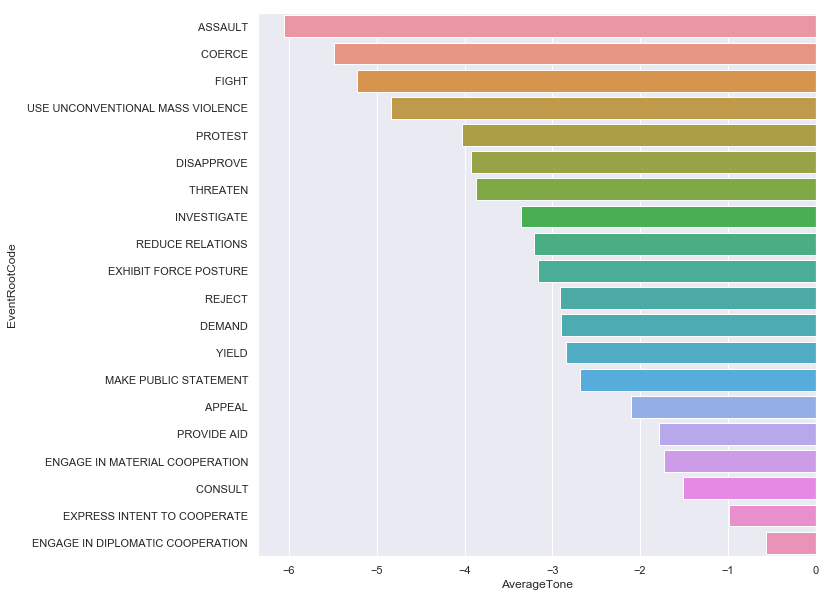

In [149]:
toPlot1 = group_by_CAMEO_df.sort_values(['AverageTone'], ascending=True)
toPlot1 = toPlot1.reset_index(drop=True)
toPlot1['EventRootCode'] = toPlot1['EventRootCode'].replace(CAMEO_translation_dict)
sn.set(rc={'figure.figsize':(10,10)})
ax = sn.barplot( toPlot1.AverageTone, toPlot1.index, orient="h")
ax.set_yticklabels(toPlot1.EventRootCode)
ax.set(xlabel='AverageTone', ylabel='EventRootCode')
fig = ax.get_figure()

At first sight, this graph seems to ne coherent with common sense. The more the event is violent or conflictual, the more it get a negative tone.
However, we notice that, indepndetly of the event type, the average tone is always negative. 

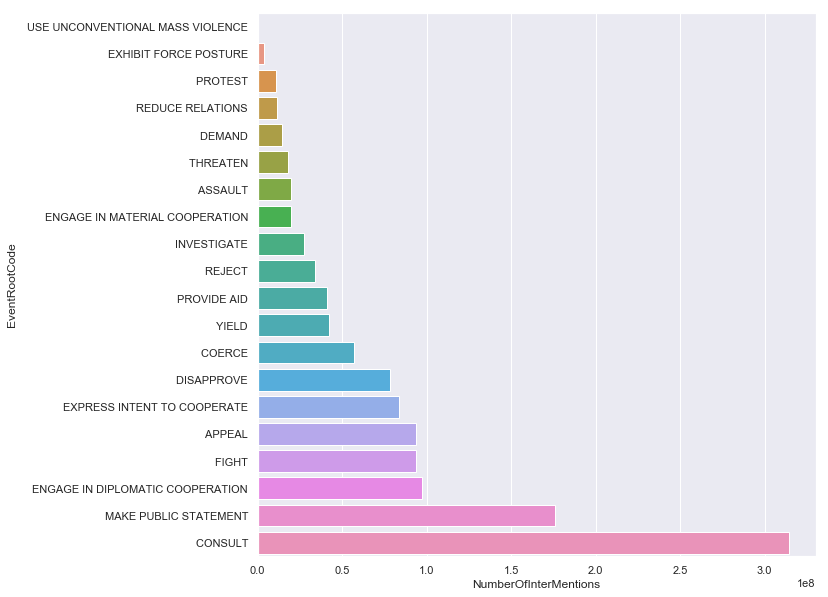

In [150]:
toPlot2 = group_by_CAMEO_df.sort_values(['NumberOfInterMentions'], ascending=True).reset_index(drop=True)
toPlot2['EventRootCode'] = toPlot2['EventRootCode'].replace(CAMEO_translation_dict)
ax = sn.barplot(toPlot2.NumberOfInterMentions, toPlot2.index, orient="h")
ax.set_yticklabels(toPlot2.EventRootCode)
ax.set(xlabel='NumberOfInterMentions', ylabel='EventRootCode')
fig = ax.get_figure()

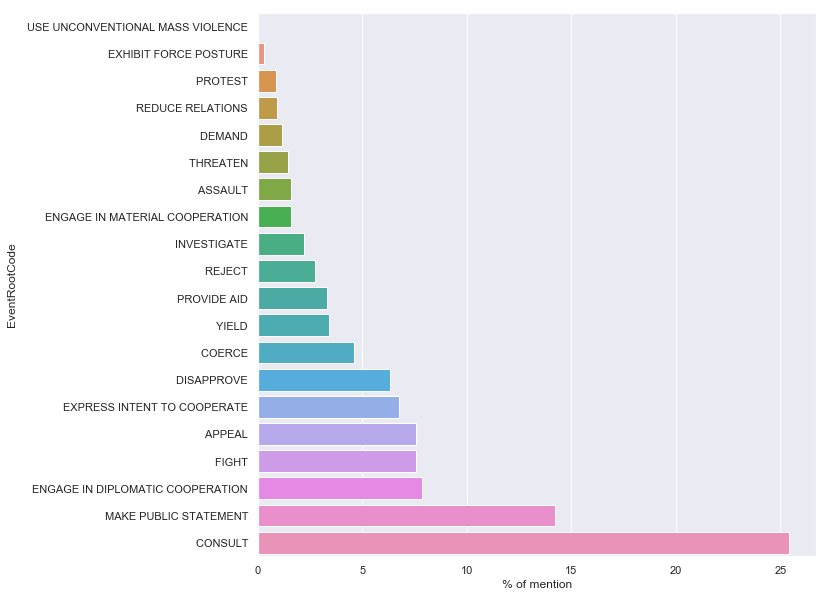

In [151]:
toPlot3 = group_by_CAMEO_df.sort_values(['NumberOfInterMentions'], ascending=True).reset_index(drop=True)
toPlot3['EventRootCode'] = toPlot3['EventRootCode'].replace(CAMEO_translation_dict)
ax = sn.barplot(x='NumberOfInterMentions', y = 'EventRootCode', data=toPlot3, orient="h", estimator= lambda x: x[0]/all_mention * 100 )
ax.set_yticklabels(toPlot3.EventRootCode)
ax.set(xlabel='% of mention', ylabel='EventRootCode')
fig = ax.get_figure()

Here we can see that the most mentionned subject are rather positive. 

In [152]:
country_mentioned = inter_country.groupby('LocMention').sum()['NumberOfInterMentions'].to_frame()
country_mentioned = country_mentioned.reset_index().sort_values(['NumberOfInterMentions'], ascending=False)
country_mentioned.head()

,LocMention,NumberOfInterMentions
216,US,554661940
214,UK,52704265
98,IN,47704266
12,AS,45143640
34,CA,30251136


In [153]:
country_mentioned.describe()

,NumberOfInterMentions
count,2.330000e+02
mean,5.312231e+06
std,3.681846e+07
min,1.300000e+01
25%,4.976800e+04
50%,4.966480e+05
75%,2.157625e+06
max,5.546619e+08


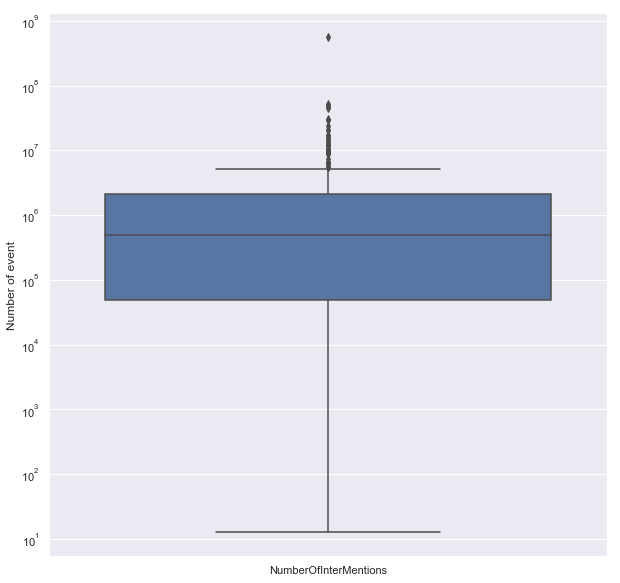

In [154]:
sn.set(rc={'figure.figsize':(10,10)})

ax = sn.boxplot(data=country_mentioned, orient="v")
ax.set(ylabel='Number of event')
ax.set_yscale("log")
fig = ax.get_figure()

There is a huge disparity in the coverage of the different countries. The dataset is mostly composed of mention of event in th US. It comes from the fact that GDELT is baed in the USA and a huge part of the sources comes from there. Since news rather talk about local event, USA is mentionned more. 

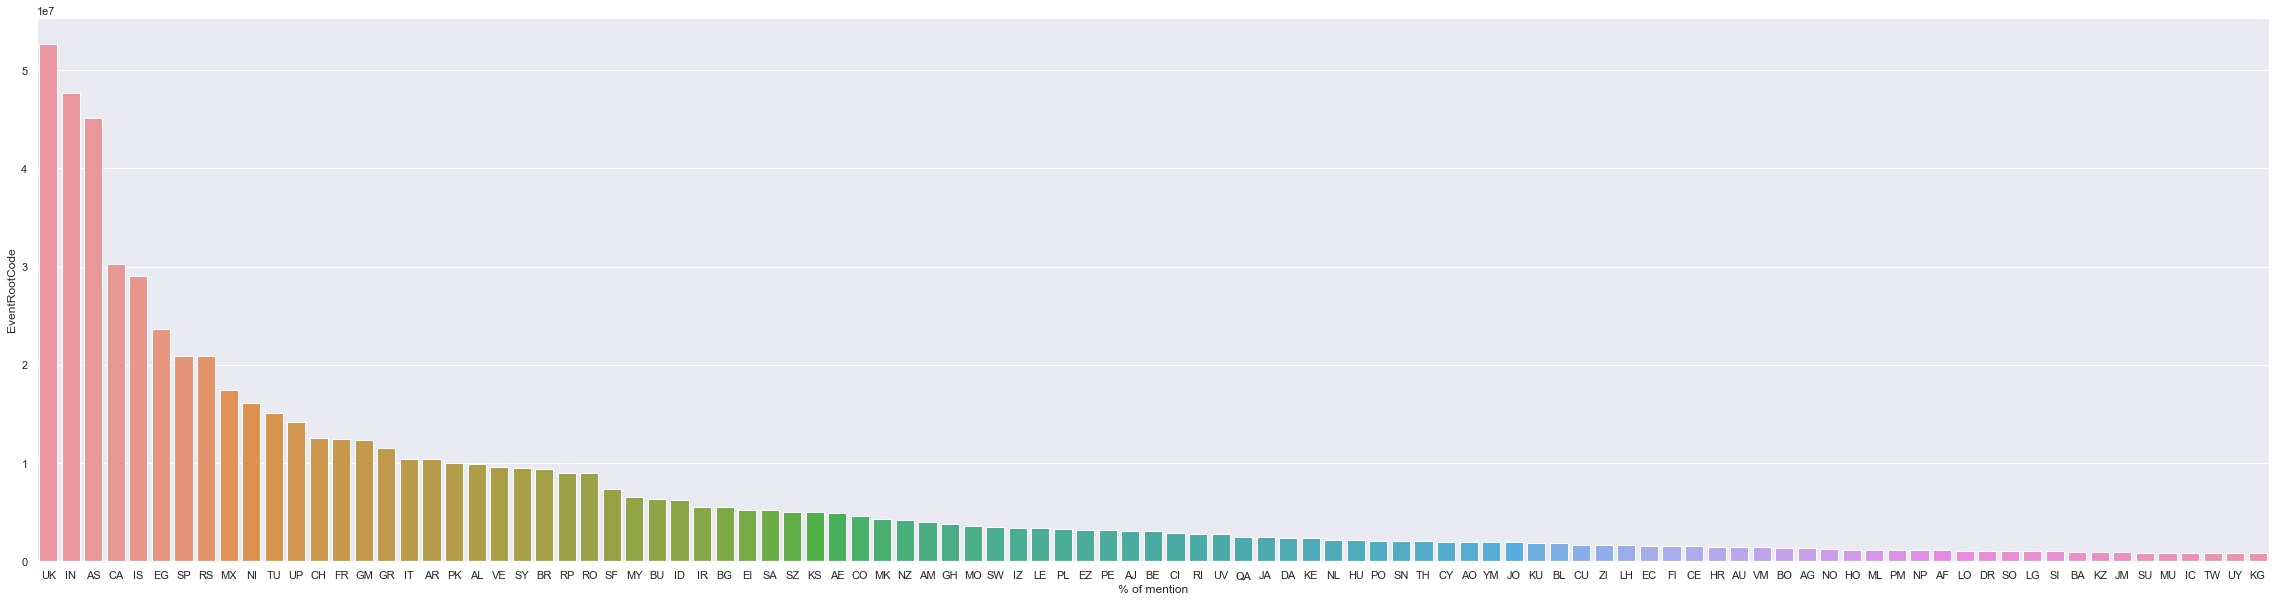

In [155]:
sn.set(rc={'figure.figsize':(40,10)})

ax = sn.barplot(x='LocMention', y = 'NumberOfInterMentions', data=country_mentioned[1:100], orient="v")
ax.set(xlabel='% of mention', ylabel='EventRootCode')
fig = ax.get_figure()

In [156]:
country_event_location = inter_country.groupby('LocEvent').sum()['NumberOfInterMentions'].to_frame()
country_event_location = country_event_location.reset_index().sort_values(['NumberOfInterMentions'], ascending=False)
country_event_location.head()

,LocEvent,NumberOfInterMentions
241,US,355497610
239,UK,47778946
201,RS,46080649
110,IS,35113199
220,SY,30221640


In [157]:
country_event_location.describe()

,NumberOfInterMentions
count,2.620000e+02
mean,4.467980e+06
std,2.281908e+07
min,6.000000e+00
25%,8.373750e+04
50%,6.663635e+05
75%,2.630226e+06
max,3.554976e+08


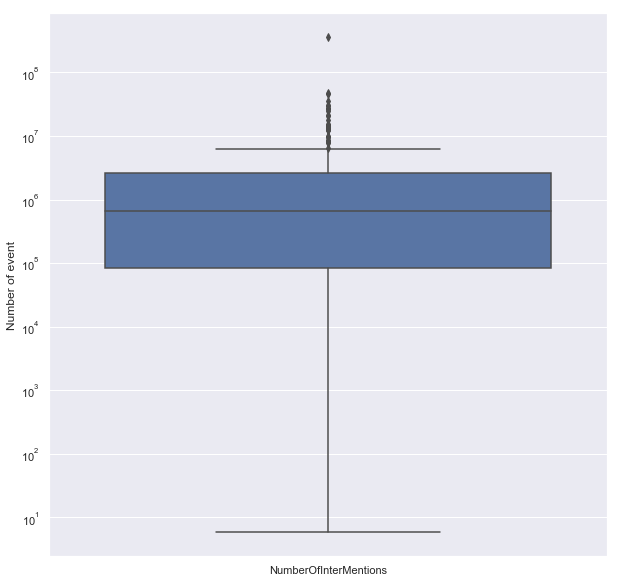

In [158]:
sn.set(rc={'figure.figsize':(10,10)})

ax = sn.boxplot(data=country_event_location, orient="v")
ax.set(ylabel='Number of event')
ax.set_yscale("log")
fig = ax.get_figure()

Since the data set is centered around the US, we will first analyze the reciprocal vision of the world vs the US. 

In [159]:
US_self = inter_country[(inter_country.LocEvent == 'US') & (inter_country.LocMention == 'US')]
US_self.head()

,EventRootCode,EventCode,LocMention,LocEvent,AverageTone,NumberOfInterMentions
2187076,10,1034,US,US,-2.926781,8
2187395,15,151,US,US,-3.608795,41461
2187440,12,1243,US,US,-5.699666,90653
2187476,02,0256,US,US,-3.362497,21773
2187492,18,185,US,US,-5.809000,14187


In [160]:
# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=US_self.loc[x.index, "NumberOfInterMentions"])

# Define a dictionary with the functions to apply for a given column:
f1 = {'NumberOfInterMentions': 'sum', 
     'AverageTone': lambda x: np.average(x, weights=US_self.loc[x.index, "NumberOfInterMentions"])}

# Groupby and aggregate with your dictionary:
US_self_grpd_CAMEO_wm = US_self.groupby(["EventRootCode"]).agg(f1)   
US_self_grpd_CAMEO_wm.head()

,NumberOfInterMentions,AverageTone
EventRootCode,,
01,48973833,-2.900924
02,24446143,-2.141017
03,17389983,-0.912860
04,66847146,-1.625520
05,21183860,-0.686615


In [300]:
US_self_grpd_all_wm = np.average(US_self_grpd_CAMEO_wm['AverageTone'], weights=US_self_grpd_CAMEO_wm['NumberOfInterMentions'])
US_self_grpd_all_wm

-2.7107840310145788

In [301]:
US_self_grpd_all_count =US_self_grpd_CAMEO_wm['NumberOfInterMentions'].sum()
US_self_grpd_all_count

299352671

In [302]:
world_to_US = inter_country[(inter_country.LocEvent == 'US') & (inter_country.LocMention != 'US')]
world_to_US.head()

,EventRootCode,EventCode,LocMention,LocEvent,AverageTone,NumberOfInterMentions
5,03,0353,IV,US,-2.439024,1
15,05,056,GV,US,-0.134953,1
49,02,0214,CB,US,-4.250807,24
53,10,1031,HK,US,-2.112676,3
87,02,0231,HA,US,-1.685139,20


In [303]:
# Define a dictionary with the functions to apply for a given column:
f_w_us_cameo = {'NumberOfInterMentions': 'sum', 
     'AverageTone': lambda x: np.average(x, weights=world_to_US.loc[x.index, "NumberOfInterMentions"])}
world_to_US_grpd_CAMEO_wm = world_to_US.groupby(["LocMention","EventRootCode"]).agg(f_w_us_cameo)   
world_to_US_grpd_CAMEO_wm.head()

NumberOfInterMentions  AverageTone
LocMention EventRootCode                                    
AA         01                                 4     2.525153
           02                                 1    -1.921470
           03                                 1     5.637467
           04                                 8     3.521914
           05                                 3     4.127487

In [304]:
f_w_us_all = {'NumberOfInterMentions': 'sum', 
     'AverageTone': lambda x: np.average(x, weights=world_to_US_grpd_CAMEO_wm.loc[x.index, "NumberOfInterMentions"])}
world_to_US_grpd_all_wm = world_to_US_grpd_CAMEO_wm.groupby('LocMention').agg(f_w_us_all)
world_to_US_grpd_all_wm.head()

,NumberOfInterMentions,AverageTone
LocMention,,
AA,19,3.212118
AC,458,-2.904458
AE,390081,-1.987494
AF,64745,-2.740300
AG,54844,-2.334884


In [305]:
world_to_US_grpd_all_wm= world_to_US_grpd_all_wm.append(pd.Series({'NumberOfInterMentions':US_self_grpd_all_count, 'AverageTone': US_self_grpd_all_wm}, name='US'))\
                        .sort_index()
world_to_US_grpd_all_wm.loc['US']

NumberOfInterMentions    2.993527e+08
AverageTone             -2.710784e+00
Name: US, dtype: float64

In [306]:
inter_mention_treshold = world_to_US_grpd_all_wm.NumberOfInterMentions.quantile(0.1)
world_to_US_grpd_all_wm.drop(world_to_US_grpd_all_wm[world_to_US_grpd_all_wm.NumberOfInterMentions < inter_mention_treshold].index, inplace=True)

In [307]:
US_to_world = inter_country[(inter_country.LocEvent != 'US') & (inter_country.LocMention == 'US')]
US_to_world.head()

,EventRootCode,EventCode,LocMention,LocEvent,AverageTone,NumberOfInterMentions
2187055,12,122,US,EG,-3.463448,803
2187056,11,113,US,IC,-4.555342,24
2187057,03,0331,US,VI,-0.449159,4
2187058,05,055,US,BR,-4.878324,1255
2187059,02,0232,US,FR,-2.490066,179


In [308]:
# Define a dictionary with the functions to apply for a given column:
f_us_w_cameo = {'NumberOfInterMentions': 'sum', 
     'AverageTone': lambda x: np.average(x, weights=US_to_world.loc[x.index, "NumberOfInterMentions"])}
US_to_world_grpd_CAMEO_wm = US_to_world.groupby(["LocEvent","EventRootCode"]).agg(f_us_w_cameo)   
US_to_world_grpd_CAMEO_wm.head()

NumberOfInterMentions  AverageTone
LocEvent EventRootCode                                    
AA       01                              4047    -2.706718
         02                              2239    -4.375275
         03                              1674     0.517300
         04                              9565    -1.781481
         05                              1089     1.635059

In [309]:
f_us_w_all = {'NumberOfInterMentions': 'sum', 
     'AverageTone': lambda x: np.average(x, weights=US_to_world_grpd_CAMEO_wm.loc[x.index, "NumberOfInterMentions"])}
US_to_world_grpd_all_wm = US_to_world_grpd_CAMEO_wm.groupby('LocEvent').agg(f_us_w_all)
US_to_world_grpd_all_wm.head()

,NumberOfInterMentions,AverageTone
LocEvent,,
AA,26151,-2.369967
AC,55358,-2.550472
AE,830206,-2.102536
AF,4617405,-4.708119
AG,251174,-4.274587


In [310]:
inter_mention_treshold2 = US_to_world_grpd_all_wm.NumberOfInterMentions.quantile(0.1)
inter_mention_treshold2

2666.0

In [311]:
US_to_world_grpd_all_wm.drop(US_to_world_grpd_all_wm[US_to_world_grpd_all_wm.NumberOfInterMentions < inter_mention_treshold2].index, inplace=True)

In [312]:
def color_function(feature, data, color_fun):
    value = data.get(feature['properties']['name'])
    if value is None:
        return '#8c8c8c' # MISSING -> gray
    if math.isnan(value):
        return '#8c8c8c' # MISSING -> gray
    else:
        return color_fun(value)

In [313]:
    
world_borders = json.load(open('../Data/world_borders.topojson.json'))
world_map = folium.Map(tiles='Mapbox bright', zoom_start=5.5)

# Defining a style function to color the map and the borders
style_func=lambda feature: {'fillColor': '#990033','color' : 'black','weight' : 2 }

 # Using a GeoJsonTooltip to display cantons' name when mouse is over them
tool=folium.features.GeoJsonTooltip(fields=['name'], aliases=['Country:'], sticky=True, \
                          style="font-family: Arial; color: black;", \
                         opacity=0.8, \
                        direction='top' \
                      )

# Load border information on the map
folium.TopoJson(world_borders,\
                object_path='objects.countries1',\
                style_function=style_func,\
                overlay=False \
               ) \
      .add_to(world_map)

In [314]:
class BindColormap(MacroElement):
    """Binds a colormap to a given layer.

    Parameters
    ----------
    colormap : branca.colormap.ColorMap
        The colormap to bind.
    """
    def __init__(self, layer, colormap):
        super(BindColormap, self).__init__()
        self.layer = layer
        self.colormap = colormap
        self._template = Template(u"""
        {% macro script(this, kwargs) %}
            {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
            {{this._parent.get_name()}}.on('overlayadd', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
                }});
            {{this._parent.get_name()}}.on('overlayremove', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'none';
                }});
        {% endmacro %}
        """)  # noqa

In [315]:
US_to_world_grpd_all_wm_dict = US_to_world_grpd_all_wm.rename(index=fips_to_country_dict)['AverageTone'].to_dict()
world_to_us_grpd_all_wm_dict = world_to_US_grpd_all_wm.rename(index=fips_to_country_dict)['AverageTone'].to_dict()

color_scale_us2w = LinearColormap(['yellow','blue'], \
                                     vmin = min(min(US_to_world_grpd_all_wm_dict.values()), min(world_to_us_grpd_all_wm_dict.values())), \
                                     vmax = max(max(US_to_world_grpd_all_wm_dict.values()), max(world_to_us_grpd_all_wm_dict.values())), \
                                     caption='World seen from US'\
                                    )


color_scale_w2us = LinearColormap(['yellow','blue'], \
                                     vmin = min(min(US_to_world_grpd_all_wm_dict.values()), min(world_to_us_grpd_all_wm_dict.values())), \
                                     vmax = max(max(US_to_world_grpd_all_wm_dict.values()), max(world_to_us_grpd_all_wm_dict.values())), \
                                     caption='US seen from the world'\
                                    )


In [316]:
map_us2w = folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, US_to_world_grpd_all_wm_dict, color_scale_us2w),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.features.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'US to world',
    )

In [317]:

map_w2us = folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, world_to_us_grpd_all_wm_dict, color_scale_w2us),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.features.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'World to US',
    )

In [318]:
world_map.add_child(map_us2w).add_child(map_w2us)
world_map.add_child(folium.map.LayerControl())

world_map.add_child(color_scale_w2us)\
         .add_child(color_scale_us2w)

world_map.add_child(BindColormap(map_us2w, color_scale_us2w)) \
         .add_child(BindColormap(map_w2us, color_scale_w2us))

world_map

# CLUSTERING

In [319]:
# Define a dictionary with the functions to apply for a given column:
f_us_w_cameo = {'NumberOfInterMentions': 'sum', 
     'AverageTone': lambda x: np.average(x, weights=inter_country.loc[x.index, "NumberOfInterMentions"])}
inter_country_CAMEO_wm = inter_country.groupby(["LocMention","LocEvent","EventRootCode"]).agg(f_us_w_cameo) 

In [320]:
inter_country_CAMEO_wm.head()

NumberOfInterMentions  AverageTone
LocMention LocEvent EventRootCode                                    
AA         AA       01                                11     0.706339
                    02                                 9     0.385537
                    03                                18     4.182802
                    04                                41     4.137846
                    05                                26     3.997235

In [321]:
total_mention = inter_country_CAMEO_wm['NumberOfInterMentions'].groupby('LocMention').sum()
total_mention.head()

LocMention
AA        237
AC       9443
AE    4814693
AF    1087476
AG    1226197
Name: NumberOfInterMentions, dtype: int64

In [322]:
df_compute_mention_ratio = inter_country_CAMEO_wm.reset_index()
df_compute_mention_ratio['NumberOfInterMentionsRatio']= df_compute_mention_ratio.apply(\
                                            lambda x : x['NumberOfInterMentions']/total_mention[x['LocMention']], axis = 1)
df_compute_mention_ratio.drop('NumberOfInterMentions', axis=1, inplace=True)
df_compute_mention_ratio = df_compute_mention_ratio.sort_values(['LocMention','LocEvent', 'EventRootCode']).set_index(['LocMention','LocEvent', 'EventRootCode'])
df_compute_mention_ratio.head()

AverageTone  NumberOfInterMentionsRatio
LocMention LocEvent EventRootCode                                         
AA         AA       01                0.706339                    0.046414
                    02                0.385537                    0.037975
                    03                4.182802                    0.075949
                    04                4.137846                    0.172996
                    05                3.997235                    0.109705

In [323]:
df_cluster_before_cleaning = df_compute_mention_ratio.unstack().unstack()
df_cluster_before_cleaning.to_csv('beforecluster.csv')
df_cluster_before_cleaning.isna().sum().sum()/df_cluster_before_cleaning.size

0.5486215313042624

In [324]:
df_cluster_before_cleaning.shape

(233, 10480)

In [335]:
#Keep only country the 150 country with the most mention
d1 = inter_country_CAMEO_wm.groupby(["LocMention", "LocEvent"]).sum()
index_to_keep = d1.groupby("LocMention").sum().sort_values("NumberOfInterMentions", ascending = False)[:150].index
df_cleaning = df_cluster_before_cleaning[df_cluster_before_cleaning.index.isin(index_to_keep)]
df_cleaning.head()

AverageTone                                                    \
EventRootCode          01                                                     
LocEvent               AA        AC        AE        AF        AG        AJ   
LocMention                                                                    
AE               0.727814  1.635967  1.333087 -5.304478 -1.832582  0.795304   
AF                    NaN       NaN -0.524948 -3.936882 -3.361447 -3.378029   
AG               2.037351       NaN -0.274156 -5.018848 -1.068607 -0.165480   
AJ                    NaN       NaN  0.592178 -4.315904 -0.458327 -0.245245   
AL                    NaN       NaN -3.334970 -4.888949 -4.895611 -3.249255   

                                                           ...       \
EventRootCode                                              ...        
LocEvent             AL        AM        AN        AO      ...        
LocMention                                                 ...        
AE            -2.673662 -2.548053  5.494012  0.408622      ...        
AF            -3.746182 -2.896494       NaN -3.680480      ...        
AG            -0.497067 -3.411952  8.456459  0.964075      ...        
AJ             0.370269 -3.290764  4.110830  1.831204      ...        
AL            -3.326084 -5.077912  3.124850       NaN      ...        

              NumberOfInterMentionsRatio                                    \
EventRootCode                         20                                     
LocEvent                              WE  WF  WI  WQ  WS  WZ            YI   
LocMention                                                                   
AE                          2.284673e-06 NaN NaN NaN NaN NaN           NaN   
AF                                   NaN NaN NaN NaN NaN NaN           NaN   
AG                          1.631059e-06 NaN NaN NaN NaN NaN           NaN   
AJ                          3.299701e-07 NaN NaN NaN NaN NaN           NaN   
AL                                   NaN NaN NaN NaN NaN NaN  5.137891e-07   

                                           
EventRootCode                              
LocEvent             YM  ZA            ZI  
LocMention                                 
AE             0.000027 NaN           NaN  
AF                  NaN NaN           NaN  
AG             0.000007 NaN           NaN  
AJ                  NaN NaN  6.599401e-07  
AL                  NaN NaN           NaN  

[5 rows x 10480 columns]

In [336]:
df_cleaning.isna().sum().sum()/ df_cleaning.size

0.39239567430025446

In [337]:
# Keep only columns with less than five missing values
df_cleaning = df_cleaning.loc[:, (df_cleaning.isna().sum(axis=0) <= 2)]
df_cleaning.to_csv('df_cleaning.csv')
df_cleaning.isna().sum().sum()/ df_cleaning.size

0.004230971128608924

In [338]:
# Fill with 0 for ratio missing values and take median of columns for Average Tone
df_cleaning['NumberOfInterMentionsRatio'] = df_cleaning['NumberOfInterMentionsRatio'].fillna(0)
df_cleaning['AverageTone'] = df_cleaning['AverageTone'].fillna(df_cleaning['AverageTone'].median())
df_cleaning.head()

AverageTone                                                    \
EventRootCode          01                                                     
LocEvent               AE        AF        AM        AR        AS        AU   
LocMention                                                                    
AE               1.333087 -5.304478 -2.548053 -1.569583 -2.588490 -1.673427   
AF              -0.524948 -3.936882 -2.896494 -0.738993 -3.397132 -3.894808   
AG              -0.274156 -5.018848 -3.411952 -1.265365 -3.737561 -1.164480   
AJ               0.592178 -4.315904 -3.290764 -0.023315 -1.191818 -0.803900   
AL              -3.334970 -4.888949 -5.077912 -0.164334 -4.496152 -0.802809   

                                                         ...     \
EventRootCode                                            ...      
LocEvent             BE        BG        BR        CA    ...      
LocMention                                               ...      
AE            -3.566036 -5.608652 -3.004553 -1.660468    ...      
AF            -3.190174 -4.137883 -3.341651 -2.856406    ...      
AG            -2.644436 -4.290590 -2.556332 -1.835319    ...      
AJ            -2.454032 -4.637422 -1.484411 -1.714632    ...      
AL             0.223287 -0.566948 -3.360419 -1.358245    ...      

              NumberOfInterMentionsRatio                                \
EventRootCode                         19                                 
LocEvent                              SF        SO        SP        SW   
LocMention                                                               
AE                              0.000158  0.000502  0.000206  0.000085   
AF                              0.000069  0.000356  0.000137  0.000049   
AG                              0.000072  0.000429  0.000414  0.000060   
AJ                              0.000043  0.000204  0.000252  0.000079   
AL                              0.000006  0.000014  0.000327  0.000051   

                                                                           
EventRootCode                                                              
LocEvent             SY        SZ        TU        UK        US        VE  
LocMention                                                                 
AE             0.009691  0.000180  0.002828  0.001517  0.005168  0.000078  
AF             0.005184  0.000076  0.001476  0.000643  0.006723  0.000020  
AG             0.010135  0.000170  0.003845  0.000779  0.003216  0.000091  
AJ             0.003252  0.000097  0.005976  0.000555  0.003278  0.000084  
AL             0.004109  0.000092  0.003355  0.000994  0.002041  0.000029  

[5 rows x 1270 columns]

In [339]:
df_cleaning.isna().sum().sum()/ df_cleaning.size

0.0

In [340]:
scaled_df = scale(df_cleaning)
scaled_df

array([[ 1.43202044, -0.32250515,  0.40376889, ...,  0.09628528,
         0.01215379, -0.27028493],
       [ 0.23571288,  0.76417831,  0.21397388, ..., -0.43267738,
         0.36210348, -0.31919561],
       [ 0.39718651, -0.09554517, -0.06679522, ..., -0.35031673,
        -0.42700281, -0.25887277],
       ...,
       [ 0.4199891 , -0.39506852, -0.77268409, ...,  0.12384897,
        -0.45274371, -0.30951688],
       [ 0.19747214, -0.66623846, -0.07688588, ..., -0.76583527,
        -1.05832389, -0.3259057 ],
       [-0.16240635, -0.97503241, -0.38903552, ..., -0.01111253,
        -0.52197852, -0.31260152]])

In [341]:
pca = PCA()
data_to_cluster = pca.fit_transform(scaled_df)
euclidean_distances(data_to_cluster)

array([[ 0.        , 57.96989792, 40.44794009, ..., 47.65081018,
        60.87330904, 44.64313886],
       [57.96989792,  0.        , 51.8995089 , ..., 58.63101886,
        73.76989207, 47.97499392],
       [40.44794009, 51.8995089 ,  0.        , ..., 42.45144488,
        59.05451153, 34.09768579],
       ...,
       [47.65081018, 58.63101886, 42.45144488, ...,  0.        ,
        70.60304754, 46.67056394],
       [60.87330904, 73.76989207, 59.05451153, ..., 70.60304754,
         0.        , 59.94614998],
       [44.64313886, 47.97499392, 34.09768579, ..., 46.67056394,
        59.94614998,  0.        ]])

In [342]:
decomp = pca.components_
decomp

array([[ 0.03419492,  0.03801906,  0.04214385, ..., -0.02151825,
        -0.03341548,  0.00032993],
       [ 0.01943752,  0.01557138,  0.00711419, ...,  0.00240764,
        -0.02558629, -0.01969186],
       [-0.02457299,  0.03932372,  0.00625522, ...,  0.01771012,
         0.01753264,  0.02927186],
       ...,
       [-0.01625842,  0.00551842, -0.03680275, ..., -0.00669486,
         0.05323533, -0.01922723],
       [ 0.03210401, -0.00965784,  0.02935271, ..., -0.00233996,
        -0.02210165,  0.00562843],
       [-0.06340545,  0.03126543,  0.08268209, ...,  0.0155684 ,
         0.02438459, -0.03392151]])

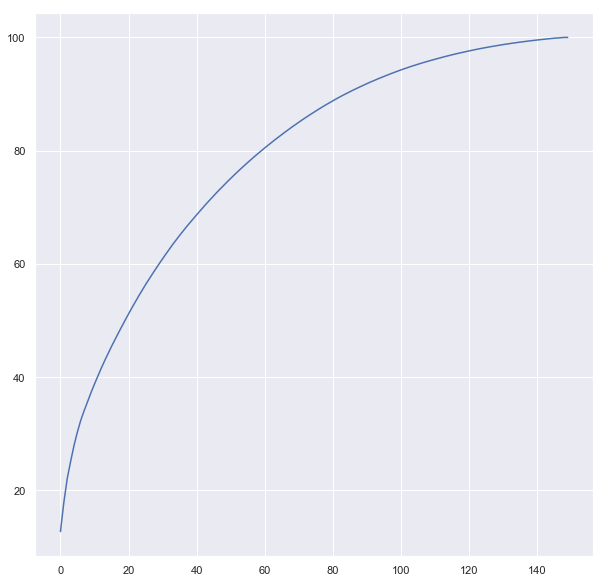

In [343]:
expl = pca.explained_variance_ratio_
plt.plot(expl.cumsum()*100)

In [344]:
def KMean_clustering(n_cluster, data): 
    KMeans_1 = KMeans(n_clusters=n_cluster)
    KMeans_1.fit(data)
    label = KMeans_1.labels_
    df = pd.DataFrame(label, index=df_cleaning.index, columns=["Label"])
    return df, metrics.silhouette_score(data, label, metric='euclidean')

In [345]:
def DBSCAN_clustering(data, eps= 75): 
    DBSCAN_1 = DBSCAN(eps = eps, min_samples=30)
    DBSCAN_1.fit(data)
    label = DBSCAN_1.labels_
    df = pd.DataFrame(label, index=df_cleaning.index, columns=["Label"])
    return df, metrics.silhouette_score(data, label, metric='euclidean')

In [346]:
def GMM_clustering(data, n_components= 2): 
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(n_components=n_components, covariance_type='full')
    label = gmm.fit_predict(data)
    df = pd.DataFrame(label, index=df_cleaning.index, columns=["Label"])
    return df, metrics.silhouette_score(data, label, metric='euclidean')

In [347]:
n_components_range = range(2, 20)
df_array_gmm = []
df_array_kmean = []
df_array_dbscan = []

score_array_gmm = []
score_array_kmean = []
score_array_dbscan = []

for k in n_components_range:
    df, score = GMM_clustering(data_to_cluster, n_components=k)
    df_array_gmm.append(df)
    score_array_gmm.append(score)
    
for k in n_components_range:
    df, score = KMean_clustering(data=data_to_cluster, n_cluster=k)
    df_array_kmean.append(df)
    score_array_kmean.append(score)
score_array_gmm

[0.12317877715411711,
 0.04025899785502612,
 0.08164004604897278,
 0.0916860048956243,
 0.001612664233187994,
 0.03050824478686606,
 0.012269838460969526,
 0.005533045560215276,
 0.021828353166994698,
 0.001482945192939253,
 -0.07195919481638073,
 -0.06158943584611476,
 -0.053830061030690476,
 -0.002097498605755916,
 -0.008312528201309496,
 -0.05646084424561959,
 0.03370629314425818,
 -0.00388250031172956]

In [348]:
score_array_kmean

[0.0780058282017662,
 0.07370730342278967,
 0.04479033464131418,
 0.04390191914054412,
 0.0369894936576931,
 0.05782149930504552,
 0.013733910523035525,
 0.026634370652290778,
 0.03859935945250512,
 0.007296529965954518,
 0.02059404820874571,
 0.02935803545189849,
 0.026460371362008194,
 0.024414108926842336,
 0.027328729923610205,
 0.0283094703842628,
 0.036693656211109,
 0.025415853230140194]

In [448]:
df1 = df_array_gmm[9]
df1.head()

,Label
LocMention,
AE,1
AF,9
AG,2
AJ,2
AL,9


In [449]:
world_borders = json.load(open('../Data/world_borders.topojson.json'))
world_map_cluster = folium.Map(tiles='Mapbox bright', zoom_start=5.5)

In [450]:
def color_function_cluster(feature, data, color_fun):
    value = data.get(feature['properties']['name'])
    if value is None:
        return '#8c8c8c' # MISSING -> gray
    if math.isnan(value):
        return '#8c8c8c' # MISSING -> gray
    else:
        return color_fun(value)

In [451]:
def data_to_plot (df1):
    cluster_data = df1.rename(index=fips_to_country_dict)["Label"]
    cluster_data.index.values[cluster_data.index.values=='United States'] = 'United States of America'
    cluster_data.index.values[cluster_data.index.values=='Serbia'] = 'Republic of Serbia'
    cluster_data = cluster_data.to_dict()
    return cluster_data

In [452]:
cluster_data = data_to_plot(df1)

In [455]:
color_scale_cluster = LinearColormap(['yellow','blue'], \
                                     vmin = min(cluster_data.values()), \
                                     vmax = max(cluster_data.values()), \
                                     caption='Cluster'\
                                    )
color_scale_cluster

In [456]:
folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, cluster_data, color_scale_cluster),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.features.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'World to US',
    ).add_to(world_map_cluster)
world_map_cluster